In [1]:
import torch 
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import numpy as np 
import torchvision.transforms as transforms
from torchvision.transforms import v2
from torch.utils.data.dataloader import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print(torch.__version__)
print(device)
NUM_CLASSES = 10

2.1.0+cu118
cuda:0


Model definition

In [105]:
'''Pre-activation ResNet in PyTorch.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Identity Mappings in Deep Residual Networks. arXiv:1603.05027
'''
import torch
import torch.nn as nn
import torch.nn.functional as F



# class PreActBottleneck(nn.Module):
#     '''Pre-activation version of the original Bottleneck module.'''
#     expansion = 4

#     def __init__(self, in_planes, planes, stride=1):
#         super(PreActBottleneck, self).__init__()
#         self.bn1 = nn.BatchNorm2d(in_planes)
#         self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(planes)
#         self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn3 = nn.BatchNorm2d(planes)
#         self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)

#         if stride != 1 or in_planes != self.expansion*planes:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
#             )

#     def forward(self, x):
#         out = F.relu(self.bn1(x))
#         shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
#         out = self.conv1(out)
#         out = self.conv2(F.relu(self.bn2(out)))
#         out = self.conv3(F.relu(self.bn3(out)))
#         out += shortcut
#         return out

# class PreActBlock(nn.Module):
#     '''Pre-activation version of the BasicBlock.'''
#     expansion = 1

#     def __init__(self, in_planes, planes, stride=1):
#         super(PreActBlock, self).__init__()
#         self.bn1 = nn.BatchNorm2d(in_planes)
#         self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(planes)
#         self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

#         if stride != 1 or in_planes != self.expansion*planes:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
#             )

#     def forward(self, x):
#         out = F.relu(self.bn1(x))
#         shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
#         out = self.conv1(out)
#         out = self.conv2(F.relu(self.bn2(out)))
#         out += shortcut
#         return out
class PreActBlock_0(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock_0, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False, groups=planes//4)
        self.dropout = nn.Dropout(0.1)
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False, groups=planes//4)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        # out = self.dropout(out)
        # out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out



class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(PreActResNet, self).__init__()
        self.in_planes = 64
        # self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        # self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        # self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        # self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        # self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)
        # self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        print(strides)
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def model_1():
    return PreActResNet(PreActBlock_0, [3,3,3,3])

def test():
    net = model_1()
    y = net((torch.randn(512,3,32,32)))

test()
from torchinfo import summary
model = model_1()
model.to(device)
print(summary(model, input_size=(512,3,32,32),verbose=0))
print(sum(p.numel() for p in model.parameters() if p.requires_grad))


[1, 1, 1]
[2, 1, 1]
[2, 1, 1]
[2, 1, 1]
[1, 1, 1]
[2, 1, 1]
[2, 1, 1]
[2, 1, 1]
Layer (type:depth-idx)                   Output Shape              Param #
PreActResNet                             [512, 10]                 --
├─Conv2d: 1-1                            [512, 64, 32, 32]         1,728
├─Sequential: 1-2                        [512, 64, 32, 32]         --
│    └─PreActBlock_0: 2-1                [512, 64, 32, 32]         --
│    │    └─BatchNorm2d: 3-1             [512, 64, 32, 32]         128
│    │    └─Conv2d: 3-2                  [512, 64, 32, 32]         2,304
│    └─PreActBlock_0: 2-2                [512, 64, 32, 32]         --
│    │    └─BatchNorm2d: 3-3             [512, 64, 32, 32]         128
│    │    └─Conv2d: 3-4                  [512, 64, 32, 32]         2,304
│    └─PreActBlock_0: 2-3                [512, 64, 32, 32]         --
│    │    └─BatchNorm2d: 3-5             [512, 64, 32, 32]         128
│    │    └─Conv2d: 3-6                  [512, 64, 32, 32]     

Dataloader generation

In [104]:
from torch.utils.data import default_collate
cutmix = v2.CutMix(alpha=1.,num_classes=NUM_CLASSES)
# mixup = v2.MixUp(alpha=0.2,num_classes=NUM_CLASSES)
# cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

def collate_fn(batch):
    return cutmix(*default_collate(batch))

## Normalization adapted for CIFAR10
normalize_scratch = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

# Transforms is a list of transformations applied on the 'raw' dataset before the data is fed to the network. 
# Here, Data augmentation (RandomCrop and Horizontal Flip) are applied to each batch, differently at each epoch, on the training set data only
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize_scratch,
])

transform_test = transforms.Compose([
    transforms.ToTensor(),

    normalize_scratch,
])

### The data from CIFAR10 will be downloaded in the following folder
rootdir = './data/cifar10'

c10train = CIFAR10(rootdir,train=True,download=True,transform=transform_train)
c10test = CIFAR10(rootdir,train=False,download=True,transform=transform_test)
## number of target samples for the final dataset
num_train_examples = len(c10train)
num_samples_subset = 7500
# num_samples_subset = num_train_examples


## We set a seed manually so as to reproduce the results easily
seed  = 2147483647


## Generate a list of shuffled indices ; with the fixed seed, the permutation will always be the same, for reproducibility
indices = list(range(num_train_examples))
np.random.RandomState(seed=seed).shuffle(indices)## modifies the list in place

## We define the Subset using the generated indices 
c10train_subset = torch.utils.data.Subset(c10train,indices[:num_samples_subset])
print(f"Initial CIFAR10 dataset has {len(c10train)} samples")
print(f"Subset of CIFAR10 dataset has {len(c10train_subset)} samples")
batch_size = 256
# Finally we can define anoter dataloader for the training data
trainloader = DataLoader(c10train,batch_size=batch_size,shuffle=True, collate_fn=collate_fn)
testloader = DataLoader(c10test,batch_size=batch_size) 
trainloader_subset = DataLoader(c10train_subset,batch_size=batch_size,shuffle=True, collate_fn=collate_fn)
### You can now use either trainloader (full CIFAR10) or trainloader_subset (subset of CIFAR10) to train your networks.
print("num of train batches",len(trainloader_subset))
print("num of test batches",len(testloader))
x = next(iter(trainloader))
print(x[0].shape, x[1].shape)

Files already downloaded and verified
Files already downloaded and verified
Initial CIFAR10 dataset has 50000 samples
Subset of CIFAR10 dataset has 7500 samples
num of train batches 30
num of test batches 40
torch.Size([256, 3, 32, 32]) torch.Size([256, 10])


Train function

In [48]:
def train(model, loader, val_loader,  optimizer, scheduler, loss_fn, n_epochs=1, save_name=False, plot_losses=False):
    start_time = time.time()
    training_losses = []
    validation_losses = []
    for e in range(n_epochs):
        print("epoch", e)
        train_loss = 0
        for i_batch, batch in enumerate(loader):
            model.train()
            optimizer.zero_grad()
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            outputs = model.forward(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            if i_batch%10==0: print("batch", i_batch, "training loss", loss.item())
        train_loss_epoch = train_loss/(i_batch+1)
        correct = 0
        total = 0
        with torch.inference_mode():
            val_loss = 0
            for i_batch, batch in enumerate(val_loader):
                model.eval()
                images, labels = batch
                images = images.to(device)
                labels = labels.to(device)
                outputs = model.forward(images)
                vloss = loss_fn(outputs, labels)
                val_loss+= vloss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            val_loss_epoch = val_loss/(i_batch+1)
        print(f'accuracy: {100 * correct / total} %')
        print("correct",correct)
        print("total",total)
        print("train_loss_epoch", train_loss_epoch)
        print("val_loss_epoch", val_loss_epoch)
        training_losses.append(train_loss_epoch)
        validation_losses.append(val_loss_epoch)
        scheduler.step(val_loss_epoch)

    training_time = start_time-time.time()
    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # print(pytorch_total_params)
    if save_name:
        torch.save({
            'accuracy': {100 * correct // total},
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'n_epochs': n_epochs,
            'batch_size':batch_size,
            'loss_fn':loss_fn.__str__,
            'total_trainable_params':pytorch_total_params,
            'training_time': training_time,
            }, "./checkpoints/"+save_name)
        
    if plot_losses:
        plt.plot(range(n_epochs),validation_losses)
        plt.plot(range(n_epochs),training_losses)
        plt.legend(['validation loss', 'training loss'])
        plt.show()

[1, 1]
[2, 1]
[2, 1]
[2, 1]
52298
epoch 0
batch 0 training loss 2.308718204498291
batch 10 training loss 2.2587709426879883
batch 20 training loss 2.208888053894043
accuracy: 21.44 %
correct 2144
total 10000
train_loss_epoch 2.2244539976119997
val_loss_epoch 2.0709928631782533
epoch 1
batch 0 training loss 2.1551482677459717
batch 10 training loss 2.178079843521118
batch 20 training loss 2.161470890045166
accuracy: 28.91 %
correct 2891
total 10000
train_loss_epoch 2.0812182386716205
val_loss_epoch 1.9018941581249238
epoch 2
batch 0 training loss 1.9839389324188232
batch 10 training loss 2.122861385345459
batch 20 training loss 1.9558571577072144
accuracy: 34.17 %
correct 3417
total 10000
train_loss_epoch 2.0104387402534485
val_loss_epoch 1.7772531688213349
epoch 3
batch 0 training loss 2.0713553428649902
batch 10 training loss 1.9933289289474487
batch 20 training loss 2.043524980545044
accuracy: 36.43 %
correct 3643
total 10000
train_loss_epoch 1.968254284063975
val_loss_epoch 1.710858

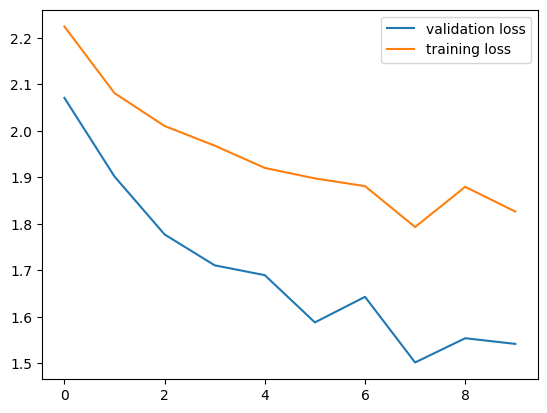

In [101]:
from torchinfo import summary
model = model_1()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
model.to(device)
optimizer = Adam(model.parameters(), lr=1e-3 , weight_decay=1e-5)
loss_fn = CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=3, min_lr=1e-8, verbose=True)
train(
    model,
    trainloader_subset,
    testloader,
    optimizer,
    scheduler,
    loss_fn,
    n_epochs=10,
    plot_losses=True
)